In [1]:
import networkx as nx
import community
import scipy as sc
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
%matplotlib inline

from load_data import load_adni
from model_evaluation import SVC_grid_search, SVC_score, exp_kernel

#### To use CommunityLouvain function you need to install community package 

0. Docs :
http://perso.crans.org/aynaud/communities/

1. Download :
https://bitbucket.org/taynaud/python-louvain/downloads

2. Installation :
https://bitbucket.org/taynaud/python-louvain

It takes aprx 2 mins to install


#### To run this notebook put it in the same directory with load_data.py and model_evaluation.py
*This directory should contain folder connectomics/ADNI/Data where ADNI data lives or just change the path during export or just export data by yourself*

In [2]:
def CommunityLouvian(data):

    part_all = []
    
    for mat in data:
        
        g = nx.Graph(mat)
        partition = community.best_partition(g)
        part_all.append(list(partition.values()))
        
    part_all = np.array(part_all)
    
    return part_all


def metric_adj(all_lbl):
    
    metric_ari = np.diag(np.ones(all_lbl.shape[0]))
    rows, cols = np.triu_indices(metric_ari.shape[0],1)
    metric_mi = metric_ari.copy()
    
    for i,j in zip(rows,cols):
            sim_ari = adjusted_rand_score(all_lbl[i], all_lbl[j])
            metric_ari[i,j] = sim_ari
            sim_mi = adjusted_mutual_info_score(all_lbl[i], all_lbl[j])
            metric_mi[i,j] = sim_mi
            
    mat_ari = metric_ari + metric_ari.T
    np.fill_diagonal(mat_ari,1)
    
    mat_mi = metric_mi + metric_mi.T
    np.fill_diagonal(mat_mi,1)
    
    return mat_ari, mat_mi

### Import ADNI Data

In [3]:
path = 'connectomics/ADNI/Data'
data, target, info = load_adni(path)

ADNI data shape                   : (807, 68, 68) 
ADNI target variable shape        : (807,) 
ADNI number of unique patients    : (255,)


### Extract AD and Normal from whole data
####   A bit of another preprocessing :
-  encoding target with 1,0;
- encoding groups with 0..107 (np.unique(groups).shape[0])
- set diagonals of all adjacency matrices to 0
-  create binarized data



In [4]:
# Extract AD and Normal from whole data
mask_AD = np.where(target == 'AD')
mask_Normal = np.where( target == 'Normal')
X = np.concatenate(( data[mask_AD], data[mask_Normal]))
y = np.concatenate((target[mask_AD], target[mask_Normal]))
groups = np.concatenate((info.subject_id.values[mask_AD], info.subject_id.values[mask_Normal]))

# encoding groups with 0..107 (np.unique(groups).shape[0])
encoding_groups = dict(zip(np.unique(groups), np.arange(np.unique(groups).shape[0])))
groups = np.array([encoding_groups.get(elem) for elem in groups])

# encoding target with 1,0;
encoding_y = {'AD' : 1, 'Normal': 0}
y = np.array([encoding_y.get(elem) for elem in y])

# set diagonals of all adjacency matrices to 0
for mat in X:
    np.fill_diagonal(mat, 0)

# create binarized data   
X_bin = np.where(X > 0, 1, 0)  

In [5]:
print(X.shape, y.shape, groups.shape)

(326, 68, 68) (326,) (326,)


In [6]:
print(np.unique(groups, return_counts = True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107]), array([2, 3, 4, 1, 2, 5, 4, 1, 4, 3, 2, 1, 1, 3, 3, 1, 2, 2, 4, 3, 2, 1, 5,
       3, 4, 5, 5, 5, 4, 2, 4, 3, 5, 2, 4, 3, 3, 3, 2, 3, 1, 2, 2, 1, 3, 1,
       1, 3, 1, 3, 1, 4, 4, 4, 3, 2, 5, 5, 4, 5, 5, 4, 4, 3, 4, 4, 5, 3, 1,
       1, 4, 5, 4, 2, 1, 3, 3, 1, 2, 4, 5, 3, 1, 1, 1, 4, 5, 4, 5, 5, 5, 4,
       5, 1, 4, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 2]))


In [7]:
print('Data : \n {} \n\n Target variable : \n {}, \n\n Groups :  \n {}'.format(X, y, groups))

Data : 
 [[[   0.    7.   68. ...,    0.    0.   80.]
  [   7.    0.    1. ...,    0.    0.    0.]
  [  68.    1.    0. ...,    0.    0.    0.]
  ..., 
  [   0.    0.    0. ...,    0.    0.   87.]
  [   0.    0.    0. ...,    0.    0.   77.]
  [  80.    0.    0. ...,   87.   77.    0.]]

 [[   0.   36.   50. ...,    0.    0.   56.]
  [  36.    0.   71. ...,    0.    0.  436.]
  [  50.   71.    0. ...,    0.    0.    3.]
  ..., 
  [   0.    0.    0. ...,    0.    0.  176.]
  [   0.    0.    0. ...,    0.    0.  114.]
  [  56.  436.    3. ...,  176.  114.    0.]]

 [[   0.    3.  228. ...,   11.    9.   39.]
  [   3.    0.    6. ...,    0.    0.   38.]
  [ 228.    6.    0. ...,    0.    0.    2.]
  ..., 
  [  11.    0.    0. ...,    0.    0.  287.]
  [   9.    0.    0. ...,    0.    0.  135.]
  [  39.   38.    2. ...,  287.  135.    0.]]

 ..., 
 [[   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  ..., 
 

### Computing partitions
#### obtaining pseudo kernels from partition (pairwise ARI, AMI)

- Original data
- Binarized data

Most time consuming part, next 2 cells take around 4-7 mins

In [8]:
louvain_partitions = CommunityLouvian(X)
louvain_partitions_bin = CommunityLouvian(X_bin)

In [9]:
p_kernel = metric_adj(louvain_partitions)
p_kernel_bin = metric_adj(louvain_partitions_bin)

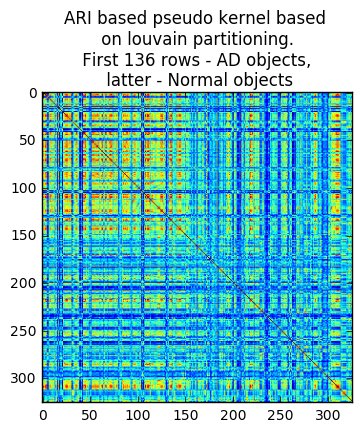

In [10]:
plt.imshow(p_kernel_bin[0]);
plt.title('ARI based pseudo kernel based \n on louvain partitioning. \n First 136 rows - AD objects, \n latter - Normal objects');

### Model selection

for details read functions description

##### IF YOUR NAME IS YULIA 
##### You should use custom kernel transform function like exp_kernel for partitions, but your own :
##### Change parameter make_kernel in SVC_grid_search and SVC_score


In [11]:
# Set parameters for grid search
params = np.array([1, 5, 10, 20], dtype=float)
penalties = np.array([0.01, 0.1, 1, 10, 50], dtype=float)

In [12]:
best_params, best_auc, train_auc_mean, train_auc_std = SVC_grid_search(p_kernel_bin[0], y, groups, 10, params, penalties,make_kernel = exp_kernel, random_state = 42)

### SVC_grid_search Output description

In [13]:
print('\nBest parameters based on grid search : {}, \nAUC for these parameters (averaged over test folds) : {:3f}'.format(best_params, best_auc))


Best parameters based on grid search : {'Kernel Parameter': 1.0, 'SVC Parameter': 1.0}, 
AUC for these parameters (averaged over test folds) : 0.802961


In [14]:
print('Mean AUCs obtained for all grid search parameters : \n{}'.format(train_auc_mean))

Mean AUCs obtained for all grid search parameters : 
[[ 0.78569256  0.78533024  0.80296104  0.77246139  0.7619601 ]
 [ 0.78993455  0.78993455  0.7875726   0.74804136  0.74804136]
 [ 0.77704701  0.77788779  0.77196733  0.74007748  0.74007748]
 [ 0.76504593  0.76561092  0.74423309  0.72757492  0.72757492]]


In [15]:
print('STD of AUCs obtained for all grid search parameters : \n{}'.format(train_auc_std))

STD of AUCs obtained for all grid search parameters : 
[[ 0.10140096  0.10146957  0.08703     0.0710491   0.0847036 ]
 [ 0.09698443  0.09698443  0.0990934   0.10454352  0.10454352]
 [ 0.11243582  0.11306153  0.10847311  0.11670439  0.11670439]
 [ 0.11103251  0.11023975  0.10859668  0.11998969  0.11998969]]


### Model evaluation

Given best params from SVC_grid_search

We now compute average auc score over 

different cross validation random states

In [16]:
param = best_params['SVC Parameter']
penalty = best_params['Kernel Parameter']
aucs = SVC_score (p_kernel_bin[0],y , groups, n_splits = 10, n_repetitions = 100, param = param, penalty = penalty, make_kernel = exp_kernel, random_state = 0)

In [17]:
print('AUC over {} repetitions is {:3f} +- {:3f}'.format(100, np.mean(aucs), np.std(aucs)))

AUC over 100 repetitions is 0.779794 +- 0.006239


In [18]:
#plt.figure(figsize=(30,5))
#plt.imshow(train_auc_mean, cmap = 'gray_r',interpolation=None, extent=[penalties[0],penalties[-1],params[0],params[-1]], origin='lower')

#ax = plt.gca()
#xticks = penalties
#yticks = params
#ax.set_xticks(xticks)
#ax.set_yticks(yticks)
#plt.colorbar()
#pass